In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [3]:
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
#!/bin/bash
!kaggle datasets download mamun1113/doctors-handwritten-prescription-bd-dataset

Dataset URL: https://www.kaggle.com/datasets/mamun1113/doctors-handwritten-prescription-bd-dataset
License(s): ODbL-1.0
 47% 9.00M/19.1M [00:00<00:00, 26.9MB/s]
100% 19.1M/19.1M [00:00<00:00, 51.6MB/s]


In [5]:
import zipfile
with zipfile.ZipFile("/content/doctors-handwritten-prescription-bd-dataset.zip", "r") as zip_ref:
    zip_ref.extractall("dataset")

In [15]:
import os
import cv2
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import layers, models

### Loading and Preprocessing Data

In [12]:

IMG_SIZE = 244  # Image size for CNN input
DATASET_PATH = 'dataset/Doctor’s Handwritten Prescription BD dataset'

def load_images_and_labels(data_type, image_folder, labels_folder):
    images = []
    labels = []

    # Paths for images and labels CSV
    image_folder = os.path.join(DATASET_PATH, data_type, image_folder)
    labels_csv = os.path.join(DATASET_PATH, data_type, labels_folder)

    # Load labels from CSV
    labels_df = pd.read_csv(labels_csv)

    for _, row in labels_df.iterrows():
        img_name = row['IMAGE']      # assuming 'image' column has the image file name
        label = row['MEDICINE_NAME']          # assuming 'label' column has the corresponding label

        # Load and preprocess the image
        img_path = os.path.join(image_folder, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

        # Append the image and label to lists
        images.append(img)
        labels.append(label)

    # Convert lists to NumPy arrays
    images = np.array(images).reshape(-1, IMG_SIZE, IMG_SIZE, 1) / 255.0  # Normalize images
    return images, labels

# Load datasets
X_train, y_train = load_images_and_labels('Training','training_words','training_labels.csv')
X_val, y_val = load_images_and_labels('Validation', 'validation_words','validation_labels.csv')
X_test, y_test = load_images_and_labels('Testing','testing_words','testing_labels.csv')


In [13]:
print(X_train.shape, len(y_train))
print(X_val.shape, len(y_val))
print(X_test.shape, len(y_test))

(3120, 244, 244, 1) 3120
(780, 244, 244, 1) 780
(780, 244, 244, 1) 780


### Encode Labels

In [9]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# Convert labels to categorical for multi-class classification
y_train_cat = tf.keras.utils.to_categorical(y_train_encoded)
y_val_cat = tf.keras.utils.to_categorical(y_val_encoded)
y_test_cat = tf.keras.utils.to_categorical(y_test_encoded)

In [16]:
len(label_encoder.classes_)

78

In [10]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [11]:
strategy = tf.distribute.MirroredStrategy()

### CNN Model

In [31]:
with strategy.scope():

    model = models.Sequential([
        # First Convolutional Block
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(244,244,1)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Second Convolutional Block
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Third Convolutional Block
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Fourth Convolutional Block
        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Flatten and Dense Layers
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(len(label_encoder.classes_), activation='softmax')
    ])    # Compile the model


    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Add callbacks for better training
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=3
        )
    ]

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [18]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 242, 242, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 242, 242, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 121, 121, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 119, 119, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 119, 119, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 59, 59, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 57, 57, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 57, 57, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 26, 26, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 26, 26, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 13, 13, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 43264)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 43264)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      22,151,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 78)                  │          40,014 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,583,502 (86.15 MB)

 Trainable params: 22,581,518 (86.14 MB)

 Non-trainable params: 1,984 (7.75 KB)

### Used data augmentation to increase generalization

In [19]:
datagen = ImageDataGenerator(rotation_range=10, zoom_range=0.1, width_shift_range=0.1, height_shift_range=0.1)
train_generator = datagen.flow(X_train, y_train_cat, batch_size=32)


### Training the model

In [32]:
# Train model
history = model.fit(
    train_generator,
    batch_size=32,
    epochs=50,
    validation_data=(X_val, y_val_cat), # Use integer labels for validation data
    callbacks=callbacks
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


98/98 ━━━━━━━━━━━━━━━━━━━━ 32s 218ms/step - accuracy: 0.0685 - loss: 5.0077 - val_accuracy: 0.0128 - val_loss: 9.2678 - learning_rate: 0.0010
Epoch 2/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 21s 203ms/step - accuracy: 0.1914 - loss: 3.6229 - val_accuracy: 0.0141 - val_loss: 12.1490 - learning_rate: 0.0010
Epoch 3/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 22s 203ms/step - accuracy: 0.2416 - loss: 3.3031 - val_accuracy: 0.0526 - val_loss: 6.2324 - learning_rate: 0.0010
Epoch 4/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 21s 202ms/step - accuracy: 0.3263 - loss: 2.7760 - val_accuracy: 0.0141 - val_loss: 9.2313 - learning_rate: 0.0010
Epoch 5/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 20s 198ms/step - accuracy: 0.4124 - loss: 2.3506 - val_accuracy: 0.0821 - val_loss: 5.4555 - learning_rate: 0.0010
Epoch 6/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 21s 206ms/step - accuracy: 0.4681 - loss: 2.1130 - val_accuracy: 0.1346 - val_loss: 4.7614 - learning_rate: 0.0010
Epoch 7/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 20s 198ms/step - accuracy: 0.5065 - loss: 1.8976 - val

In [34]:
print("Final Epoch Results:")
print(f"Training Loss: {history.history['loss'][-1]:.4f}")
print(f"Validation Loss: {history.history['val_loss'][-1]:.4f}")
print(f"Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")

Final Epoch Results:
Training Loss: 0.4996
Validation Loss: 0.6515
Training Accuracy: 0.8718
Validation Accuracy: 0.8744


In [33]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test, y_test_cat)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.8380 - loss: 0.9186
Test Accuracy: 77.18%


### Predict on New Images

In [39]:
from google.colab.patches import cv2_imshow

Input medicine Image:


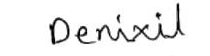

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
Predicted Medicine: Denixil


In [46]:
def recognize_medicine(img_path):
    print('Input medicine Image:')

    img = cv2.imread(img_path)
    cv2_imshow(img)

    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE)).reshape(1, IMG_SIZE, IMG_SIZE, 1) / 255.0
    prediction = model.predict(img)
    predicted_label = label_encoder.inverse_transform([np.argmax(prediction)])
    return predicted_label[0]

# Example usage
predicted_medicine = recognize_medicine('/content/dataset/Doctor’s Handwritten Prescription BD dataset/Validation/validation_words/215.png')
print(f"Predicted Medicine: {predicted_medicine}")